In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [13]:
df = pd.read_csv('lot_records.csv')
df['time'] = pd.to_datetime(df['time'], unit='s').dt.round('30min')
del df['nice_time']
df

,id,status,time
0,56,active,2023-02-02 14:30:00
1,64,na,2023-02-02 14:30:00
2,110,na,2023-02-02 14:30:00
3,73,na,2023-02-02 14:30:00
4,122,available,2023-02-02 14:30:00
...,...,...,...
16463,68,na,2023-02-06 08:00:00
16464,69,na,2023-02-06 08:00:00
16465,42,available,2023-02-06 08:00:00
16466,84,na,2023-02-06 08:00:00


In [14]:
df2 = pd.pivot(df, index='id', columns='time').status
no_status = ((df2 == 'na' )).all(axis='columns')
just_active = ((df2 == 'active' )).all(axis='columns')

df2 = df2[~no_status & ~just_active]

if set(df2.to_numpy().flatten()) != {'available', 'few', 'full'}:
    raise ValueError("df2 should only include available/few/full.")

time_columns = df2.columns

df2['grade'] = df2.apply(lambda row: row.map(dict(available=0, few=0.8, full=1)).sum(), axis='columns')
df2 = df2.sort_values(by=['grade'], ascending=False)

name_df = pd.read_csv('lot_names.csv', index_col=0)
df2['name'] = name_df['name']

df2 = df2.reindex(['name', 'grade'] + list(time_columns), axis='columns')

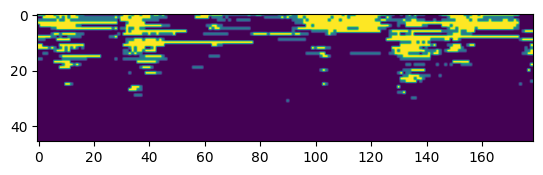

In [15]:

numeric_data = df2.drop(['grade', 'name'], axis='columns').applymap(lambda x: {'available':0, 'few': 0.8, 'full': 2}[x]).to_numpy()
plt.imshow(numeric_data)
plt.show()

In [7]:
df2.shape

(46, 144)